In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from scipy.stats import linregress
import os
from natsort import natsorted
from myusefultools.parser import pickleVolScalarField

from he_utilities import set_matplotlib_customization
set_matplotlib_customization(plt)


# Water flux over the dune lenght

Plot $\phi_\mathtt{water}$ over the dune lenght for the LES and RANS initial condition.

In [2]:
# Dune parameters
duneHeight = 0.015  # m
bedWavelenght = 0.15
hydCond = 0.00100319
depthBed = 0.20
channelWidth = 0.29
porosity = 0.358
waterDepth = 0.0975
meanVelocity = 0.15
g = 9.81

Axy = bedWavelenght*channelWidth
bedformWavenumber = 2*np.pi/bedWavelenght

In [3]:
## Read geometry of the bedform
shapeDune = pd.read_csv("./miscellaneous/shapeOfDune.csv")
shapeDune.sort_values(['Points:0', 'Points:2'], inplace=True)

## The beginning and end coordinates are the same (periodic)
## so we can discard the last x,y pair
x = shapeDune['Points:0'].iloc[::2].to_numpy()[:-1]
y = shapeDune['Points:1'].iloc[::2].to_numpy()[:-1]

## Shift arrays to make x=0 at the trough
## See np.roll documentation
where_min = np.argmin(y)
newy = np.roll(y, -where_min)


### Load results of short clean simulations

- `h`: Instantaneous head
- `hMean`: rolling-average calculated by OpenFOAM (window=10s)
- `phi`: instantaneous flux over the boundary
- `phiMean`: rolling-average calculated by OpenFOAM (window=10s)

In [4]:
variables = ["phi", "h", "hMean", "phiMean"]

LES = pickleVolScalarField(path="./subsurface_results_folder/shortClean.LES/",
                           variables=variables, keyword="top")
RAS = pickleVolScalarField(path="./subsurface_results_folder/shortClean.RANS/",
                           variables=variables, keyword="top")

## Fluxes from paraview `phi` are given in volume per time
## To convert to velocity, divide by the area of the cell
## which was extracted from Paraview
Axy_tile = 0.0008923 

In [5]:
LES.head()

,Time (s),phi,h,hMean,phiMean
0,0.0485,"[3.02353e-08, 3.48087e-08, 3.30042e-08, 2.4371...","[-0.000268376, -0.000301324, -0.000289991, -0....","[-0.000268376, -0.000301324, -0.000289991, -0....","[3.02353e-08, 3.48087e-08, 3.30042e-08, 2.4371..."
1,0.0971,"[1.98962e-08, 3.32315e-08, 4.30537e-08, 4.0604...","[-0.000201228, -0.000298735, -0.000360359, -0....","[-0.000234802, -0.000300029, -0.000325175, -0....","[2.50657e-08, 3.40201e-08, 3.8029e-08, 3.24882..."
2,0.1456,"[-2.97551e-09, 1.27514e-08, 3.51087e-08, 5.061...","[-8.11578e-06, -0.000142525, -0.000283372, -0....","[-0.00015924, -0.000247528, -0.000311241, -0.0...","[1.57187e-08, 2.69305e-08, 3.70556e-08, 3.8529..."
3,0.1942,"[-1.65191e-08, -7.17662e-09, 1.38502e-08, 4.38...","[0.000101111, -1.95418e-05, -0.000178561, -0.0...","[-9.41522e-05, -0.000190531, -0.000278071, -0....","[7.65922e-09, 1.84037e-08, 3.12542e-08, 3.9862..."
4,0.2427,"[-2.22202e-08, -1.94869e-08, -1.01244e-08, 1.5...","[0.000188158, 0.000100348, -2.50223e-05, -0.00...","[-3.76902e-05, -0.000132356, -0.000227461, -0....","[1.68333e-09, 1.08256e-08, 2.29785e-08, 3.4992..."


### Check time-invariance of fluxes on a clean bed - turbulent simulation

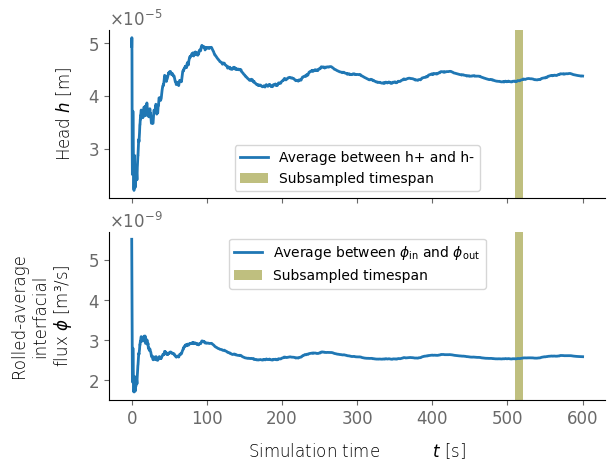

In [6]:
TIMESPAN = (510, 520)

fig, axs = plt.subplots(2,1, sharex=True)

## Head distribution
ax = axs[0]

ax.plot(
    LES['Time (s)'], 
    [(np.average(np.maximum(i,0)) - np.average(np.minimum(i,0)))/2 for i in LES['hMean']],
    lw=2, label="Average between h+ and h-")
ax.set_ylabel("Head $h$ [m]")


## Flux distribution
ax = axs[1]

ax.plot(
    LES['Time (s)'], 
    [(np.average(np.maximum(i,0)) - np.average(np.minimum(i,0)))/2 for i in LES['phiMean']],
    lw=2, label="Average between $\phi_{\\rm in}$ and $\phi_{\\rm out}$")

ax.set_xlabel("Simulation time \t $t$ [s]")
ax.set_ylabel("Rolled-average\ninterfacial\nflux $\phi$ [m³/s]")

for ax in axs:
    ax.axvspan(*TIMESPAN, alpha=0.5, facecolor='olive', label="Subsampled timespan")
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
    ax.legend()
plt.show()

In [7]:
subsampleLES = LES[LES['Time (s)'].between(*TIMESPAN)]
subsampleLES.tail()

,Time (s),phi,h,hMean,phiMean
10707,519.7931,"[-2.91034e-08, -3.48971e-08, -3.89603e-08, -3....","[0.000591794, 0.000560816, 0.000503493, 0.0003...","[0.000207793, 0.000213474, 0.000212964, 0.0002...","[-9.70913e-09, -1.07616e-08, -1.10912e-08, -1...."
10708,519.8416,"[-2.5234e-08, -2.61022e-08, -2.82111e-08, -3.8...","[0.000577351, 0.000557109, 0.000532119, 0.0005...","[0.000207828, 0.000213506, 0.000212994, 0.0002...","[-9.71058e-09, -1.07631e-08, -1.10928e-08, -1...."
10709,519.8902,"[-2.76871e-08, -2.75165e-08, -2.12907e-08, -2....","[0.000551484, 0.00054011, 0.000505017, 0.00047...","[0.00020786, 0.000213536, 0.000213021, 0.00020...","[-9.71226e-09, -1.07646e-08, -1.10938e-08, -1...."
10710,519.9387,"[-2.31371e-08, -2.87772e-08, -2.69825e-08, -2....","[0.000485206, 0.000503946, 0.000491114, 0.0004...","[0.000207886, 0.000213563, 0.000213047, 0.0002...","[-9.71351e-09, -1.07663e-08, -1.10952e-08, -1...."
10711,519.9873,"[-1.34432e-08, -2.05826e-08, -2.52379e-08, -2....","[0.000389769, 0.000421621, 0.000439078, 0.0004...","[0.000207903, 0.000213583, 0.000213068, 0.0002...","[-9.71386e-09, -1.07672e-08, -1.10966e-08, -1...."


In [8]:
## Calculate the mean head from the instantaneous values
h_mean_from_instantaneous = subsampleLES['h'].mean()

## Calculate the mean flux from the instantaneous values
# <-- For some reason this time average differs from the one from OpenFoam
phi_mean_from_instantaneous = subsampleLES['phi'].mean()

### Compare steady head with instantaneous burst

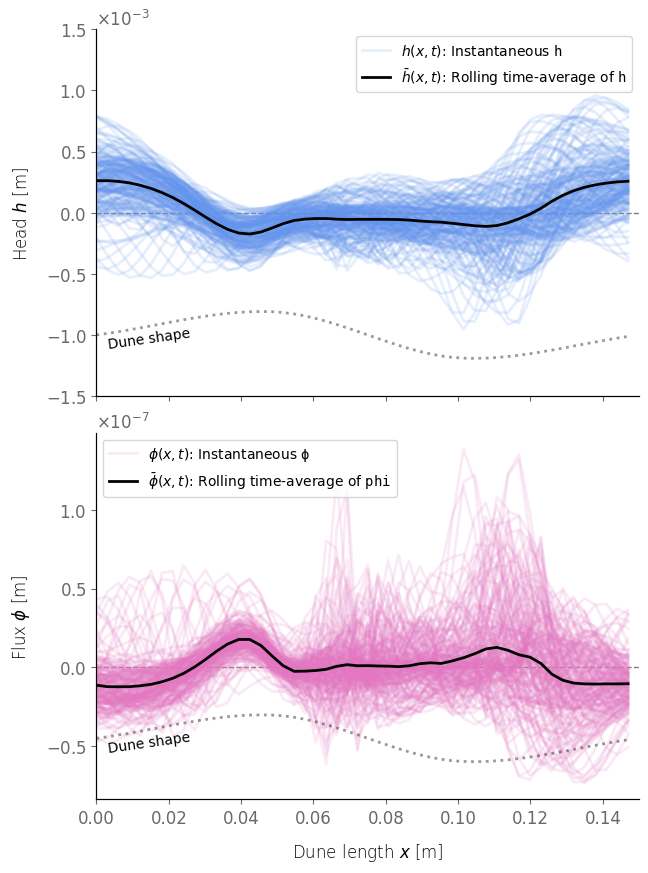

In [9]:
fig, axs = plt.subplots(2,1, figsize=[7,10], sharex=True, gridspec_kw={'hspace':0.1})

## Plot all the h distributions
ax = axs[0]
instant_kwargs = dict(alpha=0.15, lw=2, c='cornflowerblue', zorder=2)

x24 = np.delete(x, [24])
for i in subsampleLES['h']:
    ax.plot(x24, np.delete(i, [24]), **instant_kwargs)

ax.plot(x24, np.delete(i, [24]), label=r"$h(x,t)$: Instantaneous $\mathtt{h}$", **instant_kwargs)

ax.plot(x, h_mean_from_instantaneous, 
        lw=2, c='k', zorder=3,
        label=r"$\bar{h}(x,t)$: Rolling time-average of $\mathtt{h}$")

ax.set_ylabel("Head $h$ [m]")
ax.set_ylim(-1.5e-3, 1.5e-3)


## Plot all the phi distributions
ax = axs[1]
instant_kwargs = dict(alpha=0.15, lw=2, c='tab:pink', zorder=2)

for i in subsampleLES['phi']:
    ax.plot(x, i, **instant_kwargs)

ax.plot(x, i, label=r"$\phi(x,t)$: Instantaneous $\mathtt{\phi}$", **instant_kwargs)

ax.plot(x, phi_mean_from_instantaneous, 
        lw=2, c='k', zorder=3,
        label=r"$\bar{\phi}(x,t)$: Rolling time-average of $\mathtt{phi}$")

ax.set_xlabel("Dune length $x$ [m]")
ax.set_ylabel("Flux $\phi$ [m]")

for ax in axs:
    ax.set_xlim(0, 0.15)
    ax.axhline(y=0, lw=1, c='gray', ls='dashed', zorder=1)
    ax.legend()
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)

    ## Dune shape
    ax2 = ax.twinx()
    ax2.plot(x, y, label="Dune shape", lw=2, c='k', alpha=0.4, ls='dotted')
    ax2.set_ylim(-0.02, 0.10)
    ax2.get_yaxis().set_visible(False)
    ax2.text(0.02, 0.13, "Dune shape", transform=ax2.transAxes, rotation=8, fontsize=10)

plt.show()


### `Debugging`:

`phiMean` from OpenFOAM differs from the averaged instantaneous values. 

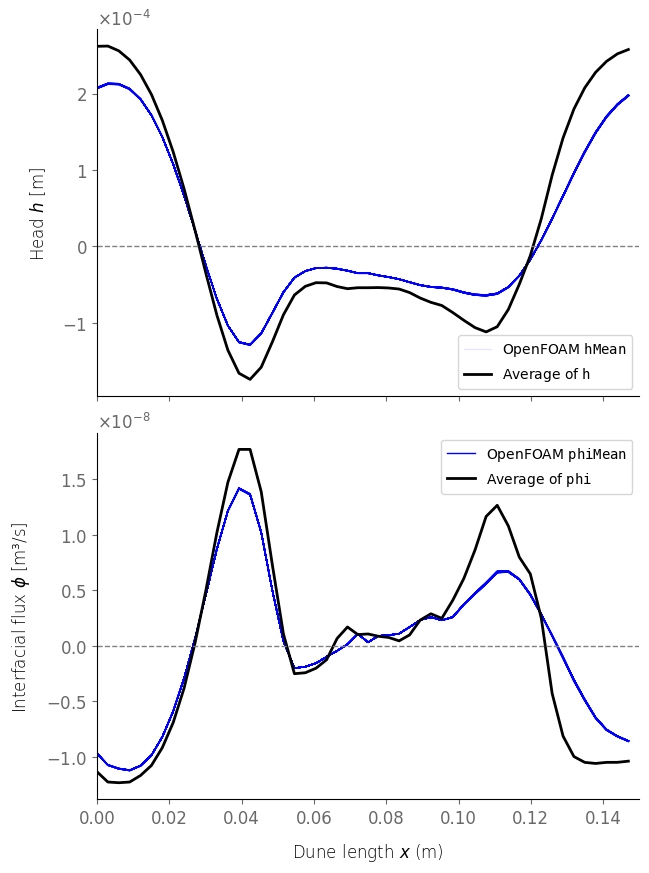

In [11]:
fig, axs = plt.subplots(2,1, figsize=[7,10], sharex=True, gridspec_kw={'hspace':0.1})

## Plot all the hMean distributions
ax = axs[0]
for i in subsampleLES['hMean']: # <-- they should be very much the same (but not quite)
    ax.plot(x, i, alpha=0.1, lw=1, c='b')

ax.plot(x, i, alpha=0.1, lw=1, c='b', label=r"OpenFOAM $\mathtt{hMean}$")
ax.plot(x, h_mean_from_instantaneous, lw=2, c='k', label=r"Average of $\mathtt{h}$")

ax.set_ylabel("Head $h$ [m]")


## Plot all the phiMean distributions
ax = axs[-1]
for i in subsampleLES['phiMean']: # <-- they should be very much the same (but not quite)
    ax.plot(x, i, alpha=0.1, lw=1, c='b')

ax.plot(x, i, lw=1, c='b', label=r"OpenFOAM $\mathtt{phiMean}$")
ax.plot(x, phi_mean_from_instantaneous, lw=2, c='k', label=r"Average of $\mathtt{phi}$")

ax.set_ylabel("Interfacial flux $\phi$ [m³/s]")
ax.set_xlabel("Dune length $x$ (m)")
for ax in axs:
    ax.axhline(y=0, lw=1, c='gray', ls='dashed')
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
    ax.legend()
    ax.set_xlim(0, 0.15)

plt.show()

> There is a discrepancy between OpenFOAM's `fieldAverageOverTime` and 
> calculating the average over time from the instantaneous data.

## Separate the instantaneous flux between in- and out-

In [12]:
## Influx corresponds to the negative fluxes
subsampleLES["ma.phi.min"] = [np.minimum(i, 0) for i in subsampleLES['phi']]

## Outflux corresponds to the negative fluxes
subsampleLES["ma.phi.max"] = [np.maximum(i, 0) for i in subsampleLES['phi']]

/tmp/ipykernel_37551/2588535439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsampleLES["ma.phi.min"] = [np.minimum(i, 0) for i in subsampleLES['phi']]
/tmp/ipykernel_37551/2588535439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsampleLES["ma.phi.max"] = [np.maximum(i, 0) for i in subsampleLES['phi']]


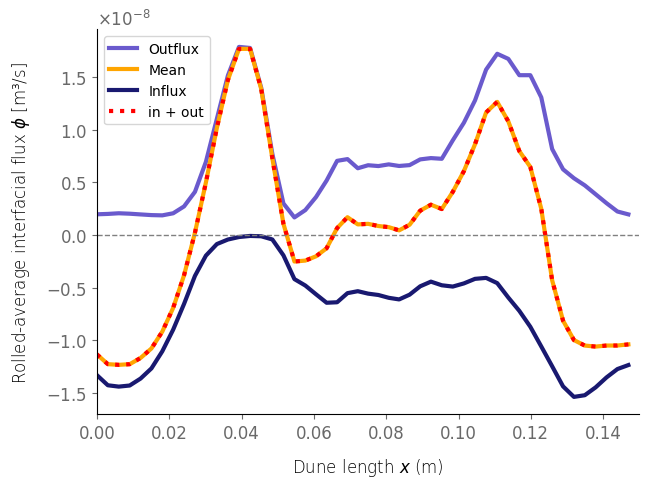

In [13]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(x, subsampleLES['ma.phi.max'].mean(), label=r"Outflux", c='slateblue', lw=3)
ax.plot(x, phi_mean_from_instantaneous, label="Mean", c='orange', lw=3)
ax.plot(x, subsampleLES['ma.phi.min'].mean(), label=r"Influx", c='midnightblue', lw=3)

## The sum on influx and outflux is the same as the mean of the instantaneous flux
ax.plot(x, subsampleLES['ma.phi.min'].mean() + subsampleLES['ma.phi.max'].mean(), 
        lw=3, c='r', ls='dotted', label="in + out")

ax.axhline(y=0, lw=1, c='gray', ls='dashed')

## Misc
ax.set_xlabel("Dune length $x$ (m)")
ax.set_ylabel("Rolled-average interfacial flux $\phi$ [m³/s]")
ax.set_xlim(0, 0.15)
ax.legend()
ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)

plt.show()


## Calculate analytical solution 

Use Eq. 24 from Packman & Brooks (2001) with no settling velocity and evaluated at y=0 (interface)

In [14]:
# Calculate sine head distribution
exponentForHeadm = 3/2 if duneHeight/waterDepth > 0.34 else 3/8
head_m = 0.28 * meanVelocity**2 / (2*g) * np.power(duneHeight/waterDepth/0.34, exponentForHeadm)
print("h_m = {:.3E} m".format(head_m))

h_m = 2.385E-04 m


In [15]:
2*np.pi/0.15

41.88790204786391

In [16]:
# Calculate head and flux (vertical velocity) distributions
h_Packman = head_m*np.sin(bedformWavenumber*(x + bedWavelenght/4))

v_Packman = -bedformWavenumber*hydCond*head_m * \
    np.sin(bedformWavenumber*(x + bedWavelenght/4))*np.tanh(bedformWavenumber*depthBed)

catx = np.concatenate([x, x+bedWavelenght])


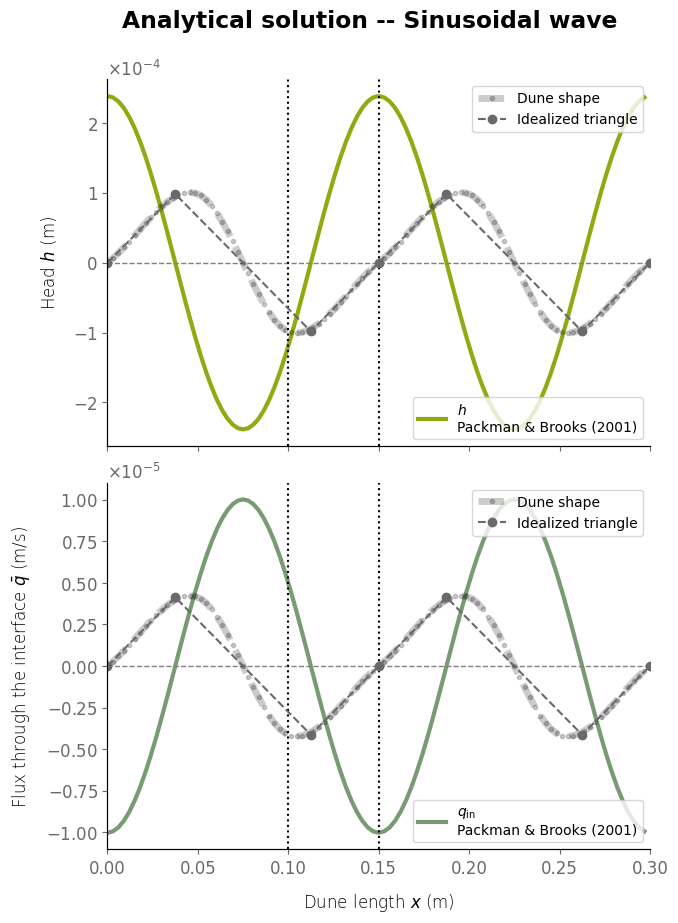

In [17]:
fig, axs = plt.subplots(2,1, figsize=[7,10], sharex=True, gridspec_kw={'hspace':0.1})

## Head distribution
ax = axs[0]
ax.plot(catx, np.tile(h_Packman, 2), 
    c="xkcd:pea green", lw=3, label="$h$\nPackman & Brooks (2001)")

ax.set_ylabel("Head $h$ (m)")

## Interfacial flux
ax = axs[1]
ax.plot(catx, np.tile(v_Packman, 2), 
    c="xkcd:grey green", lw=3, label="$q_{\\rm in}$\nPackman & Brooks (2001)")
ax.set_xlabel("Dune length $x$ (m)")
ax.set_ylabel(r"Flux through the interface $\bar{q}$ (m/s)")

## Dune shape
for ax in axs:
    ax2 = ax.twinx()
    ax2.plot(catx, np.tile(y, 2), marker='.',
        label="Dune shape", lw=5, c='k', alpha=0.2, ls='dashed')

    ax2.plot(
        [0, 0.0375, 0.1125, 0.15, 0.1875, 0.2625, 0.30],
        [0, duneHeight/2, -duneHeight/2, 0, duneHeight/2, -duneHeight/2, 0],
        label="Idealized triangle", marker='o', ls='dashed', c='dimgray'
    )

    ## Misc
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(-0.02, 0.02)
    ax2.set_xlim(0, 0.30)
    ax2.set(ylabel="Dune height (cm)")
    ax2.legend()

    ax.axhline(y=0, lw=1, c='gray', ls='dashed')
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
    ax.legend(loc='lower right')
    ax.axvline(0.10, ls='dotted', c='k')
    ax.axvline(0.15, ls='dotted', c='k')

fig.suptitle("Analytical solution -- Sinusoidal wave", y=0.95, fontweight=700)
plt.show()

### Compare analytical with actual pressure distribution

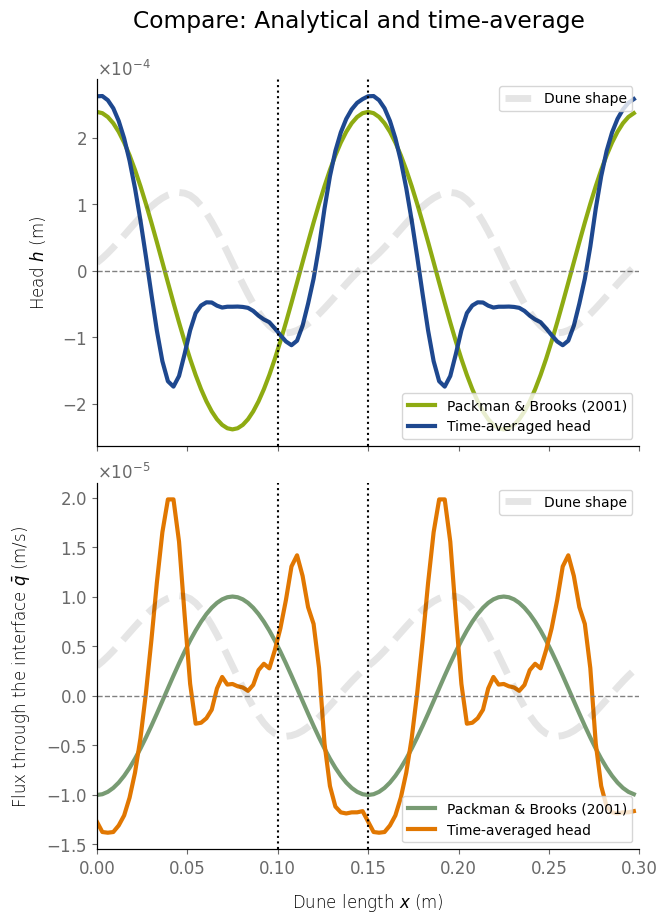

In [18]:
fig, axs = plt.subplots(2,1, figsize=[7,10], sharex=True, gridspec_kw={'hspace':0.1})

## HEAD 
ax = axs[0]

## Analytical head 
ax.plot(catx, np.tile(h_Packman, 2), 
    c="xkcd:pea green", lw=3, label="Packman & Brooks (2001)")

## Distribution from time-averaged model
ax.plot(catx, np.tile(h_mean_from_instantaneous, 2), 
    c="xkcd:cobalt", lw=3, label="Time-averaged head")

ax.set_ylabel("Head $h$ (m)")

## FLUX
ax = axs[1]

## Analytical flux
ax.plot(catx, np.tile(v_Packman, 2), 
    c="xkcd:grey green", lw=3, label="Packman & Brooks (2001)")

ax.plot(catx, np.tile(phi_mean_from_instantaneous, 2)/Axy_tile, 
    c="xkcd:pumpkin", lw=3, label="Time-averaged head")

ax.set_xlabel("Dune length $x$ (m)")
ax.set_ylabel(r"Flux through the interface $\bar{q}$ (m/s)")

## Dune shape
for ax in axs:
    ax2 = ax.twinx()
    ax2.plot(catx, np.tile(y, 2),
        label="Dune shape", lw=5, c='k', alpha=0.1, ls='dashed')

    # ax2.plot(
    #     [0, 0.0375, 0.1125, 0.15, 0.1875, 0.2625, 0.30],
    #     [0, duneHeight/2, -duneHeight/2, 0, duneHeight/2, -duneHeight/2, 0],
    #     label="Idealized triangle", marker='o', ls='dashed', c='dimgray'
    # )

    ## Misc
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(-0.02, 0.02)
    ax2.set_xlim(0, 0.30)
    ax2.set(ylabel="Dune height (cm)")
    ax2.legend()

    ax.axhline(y=0, lw=1, c='gray', ls='dashed')
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
    ax.legend(loc='lower right')
    ax.axvline(0.10, ls='dotted', c='k')
    ax.axvline(0.15, ls='dotted', c='k')

fig.suptitle("Compare: Analytical and time-average", y=0.95, fontweight=500)
plt.show()

# Figure 1b

In [18]:
flux_out = subsampleLES['ma.phi.max'].mean()/Axy_tile
flux_in = subsampleLES['ma.phi.min'].mean()/Axy_tile
flux_net = phi_mean_from_instantaneous/Axy_tile

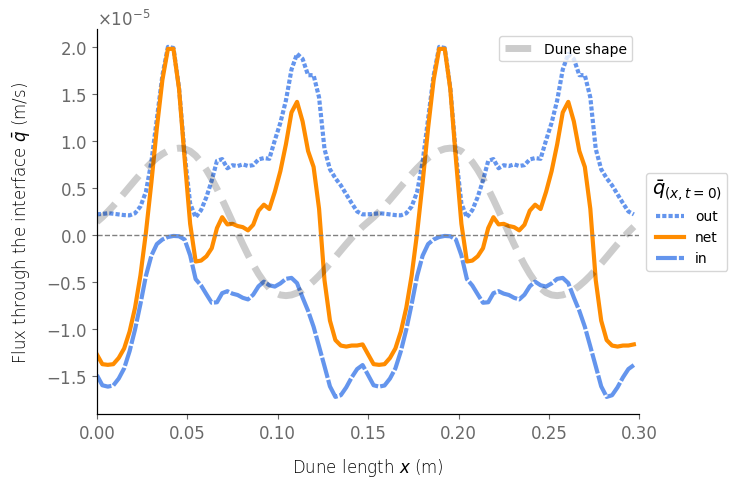

In [19]:
fig, ax = plt.subplots(figsize=[7, 5])
ax2 = ax.twinx()

## Distributions from time-averaged model (OUT)
ax.plot(catx, np.tile(flux_out, 2), 
    c="cornflowerblue", lw=3, label="out", ls=(0, (1, 0.5)))

## Distribution from time-averaged model (NET)
ax.plot(catx, np.tile(flux_net, 2), 
    c="darkorange", lw=3, label="net")

## Distribution from time-averaged model (IN)
ax.plot(catx, np.tile(flux_in, 2), 
    c="cornflowerblue", lw=3, label="in", ls=(0, (5, 0.5)))


## Dune shape
ax2.plot(
    catx, 
    np.tile(y, 2), 
    label="Dune shape", lw=5, c='k', alpha=0.2, ls='dashed')

## Misc
ax2.get_yaxis().set_visible(False)
ax2.set_ylim(-0.02, 0.02)
ax2.set_xlim(0, 0.30)
ax2.legend()

ax.axhline(y=0, lw=1, c='gray', ls='dashed')
ax.set_xlabel("Dune length $x$ (m)")
ax.set_ylabel(r"Flux through the interface $\bar{q}$ (m/s)")
ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
ax.legend(title=r"$\bar{q}_{(x, t=0)}$", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Extracting influx and outflux from timeseries

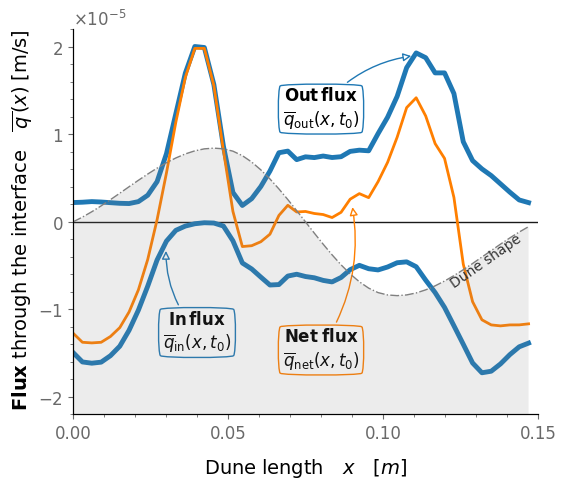

In [20]:
fig, ax = plt.subplots(figsize=[6, 5])
ax2 = ax.twinx()

## Flux distributions
ax.plot(x, flux_out, c="#1f78b4", lw=3.5)    ## OUT
ax.plot(x, flux_net, c="#ff7f00", lw=2)    ## NET
ax.plot(x, flux_in,  c="#1f78b4", lw=3.5)  ## IN

## Dune shape
ax2.plot(x, y, lw=1, c='gray', ls='-.', zorder=1)
ax2.text(0.97, 0.40, "Dune shape", va='center', ha='right', c='0.2',
         transform=ax2.transAxes, rotation=35, fontsize=10, fontweight=300)
ax2.fill_between(x, y, -1, fc='gray', alpha=0.15)

## Annotations
ann = ax.annotate(r"$\mathbf{Out \, flux}$" "\n" r"$\overline{q}_{\mathsf{out}}(x,t_0)$",
                xy=(0.11, 1.9E-5), xycoords='data',
                xytext=(0.08, 1.3E-5), textcoords='data',
                size=12, va="center", ha="center",
                bbox=dict(boxstyle="round4", fc="None", ec="#1f78b4"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w", ec="#1f78b4"))

ann = ax.annotate(r"$\mathbf{In \, flux}$"  "\n" r"$\overline{q}_{\mathsf{in}}(x,t_0)$",
                xy=(0.03, -0.3E-5), xycoords='data',
                xytext=(0.04, -1.5E-5), textcoords='data',
                size=12, va="bottom", ha="center",
                bbox=dict(boxstyle="round4", fc="None", ec="#1f78b4"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w", ec="#1f78b4"))

ann = ax.annotate(r"$\mathbf{Net \; flux}$" "\n" r"$\overline{q}_{\mathsf{net}}(x,t_0)$",
                xy=(0.09, 0.2E-5), xycoords='data',
                xytext=(0.08, -1.70E-5), textcoords='data',
                size=12, va="bottom", ha="center",
                bbox=dict(boxstyle="round4", fc="None", ec="#ff7f00"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2",
                                fc="w", ec="#ff7f00"))

## Misc
ax2.get_yaxis().set_visible(False)
ax2.set_ylim(-0.02, 0.02)
ax2.set_xlim(0, bedWavelenght)

ax.set_xlim(0, bedWavelenght)
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.xaxis.set_major_locator(MultipleLocator(0.05))

ax.set_ylim(-2.2e-5, 2.2e-5)
ax.yaxis.set_major_locator(MultipleLocator(1.0e-5))
ax.yaxis.set_minor_locator(MultipleLocator(0.2e-5))

ax.axhline(y=0, lw=1, c='0.1', zorder=1)
# ax.set_xlabel("Dune length $x$ [m]")
# ax.set_ylabel(r"Flux through the interface $\bar{q}$ [m/s]")

## Axis labels
ax.set_xlabel(
    r'${\rm Dune \; length} \quad x \quad  [m]$', fontsize=14)

fig.supylabel(
    r'$\mathbf{Flux}$ through the interface' + '\t' +
    r'$\overline{\,q\,}(x) \; \mathsf{[m/s]}$',
    x=0.02, fontsize=14)

ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0], useMathText=True)
# ax.grid(which='both', visible=True, zorder=1)
# plt.savefig("Fig1.b-FluxesOverDune.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()